In [10]:
import yfinance as yf
import pandas as pd


tickers = ["AAPL", "MSFT", "AMZN", "GOOGL", "META"]

# Define a function to fetch and save data
def fetch_data(ticker_list, start_date="2018-01-01", end_date="2023-01-01"):
    for ticker in ticker_list:
        data = yf.download(ticker, start=start_date, end=end_date)
        data.to_csv(f"{ticker}_data.csv")
        print(f"Data for {ticker} saved!")
fetch_data(tickers)

[*********************100%%**********************]  1 of 1 completed
Data for AAPL saved!
[*********************100%%**********************]  1 of 1 completed
Data for MSFT saved!
[*********************100%%**********************]  1 of 1 completed
Data for AMZN saved!
[*********************100%%**********************]  1 of 1 completed
Data for GOOGL saved!
[*********************100%%**********************]  1 of 1 completed
Data for META saved!


In [11]:
stock_data = {}
for ticker in tickers:
    stock_data[ticker] = pd.read_csv(f"{ticker}_data.csv", index_col="Date", parse_dates=True)

In [12]:
def compute_indicators(df):
    # Moving Averages
    df['MA_50'] = df['Close'].rolling(window=50).mean()
    df['MA_200'] = df['Close'].rolling(window=200).mean()
    
    # Bollinger Bands
    df['Rolling_STD'] = df['Close'].rolling(window=20).std()
    df['Upper_Band'] = df['MA_50'] + (df['Rolling_STD']*2)
    df['Lower_Band'] = df['MA_50'] - (df['Rolling_STD']*2)
    
    # Relative Strength Index (RSI)
    delta = df['Close'].diff(1)
    gain = (delta.where(delta > 0)).fillna(0)
    loss = (-delta.where(delta < 0)).fillna(0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    return df

# Apply the function to our stock data
for ticker, data in stock_data.items():
    stock_data[ticker] = compute_indicators(data)

In [13]:
from sklearn.model_selection import train_test_split

# Define a function to prepare data
def prepare_data(df):
    # Drop rows with NaN values
    df = df.dropna()
    
    # Calculate next day's return (our target variable)
    df['Next_Return'] = df['Close'].pct_change().shift(-1)
    
    # Drop rows with NaN values created by the shift operation
    df = df.dropna()
    
    # Features and target
    X = df[['MA_50', 'MA_200', 'Upper_Band', 'Lower_Band', 'RSI']]
    y = df['Next_Return']
    
    # Split data into training and testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test

# For Jupyter Notebook, to suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Define a function to train and evaluate the model
def train_evaluate(X_train, X_test, y_train, y_test):
    # Initialize the model
    model = LinearRegression()
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    predictions = model.predict(X_test)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, predictions)
    
    return model, mse

# Prepare data and train the model for each stock
models = {}
mse_values = {}

for ticker in stock_data.keys():
    X_train, X_test, y_train, y_test = prepare_data(stock_data[ticker])
    models[ticker], mse_values[ticker] = train_evaluate(X_train, X_test, y_train, y_test)

# Print out the MSE for each stock
for ticker, mse in mse_values.items():
    print(f"MSE for {ticker}: {mse:.6f}")

MSE for AAPL: 0.000532
MSE for MSFT: 0.000470
MSE for AMZN: 0.000462
MSE for GOOGL: 0.000430
MSE for META: 0.000656


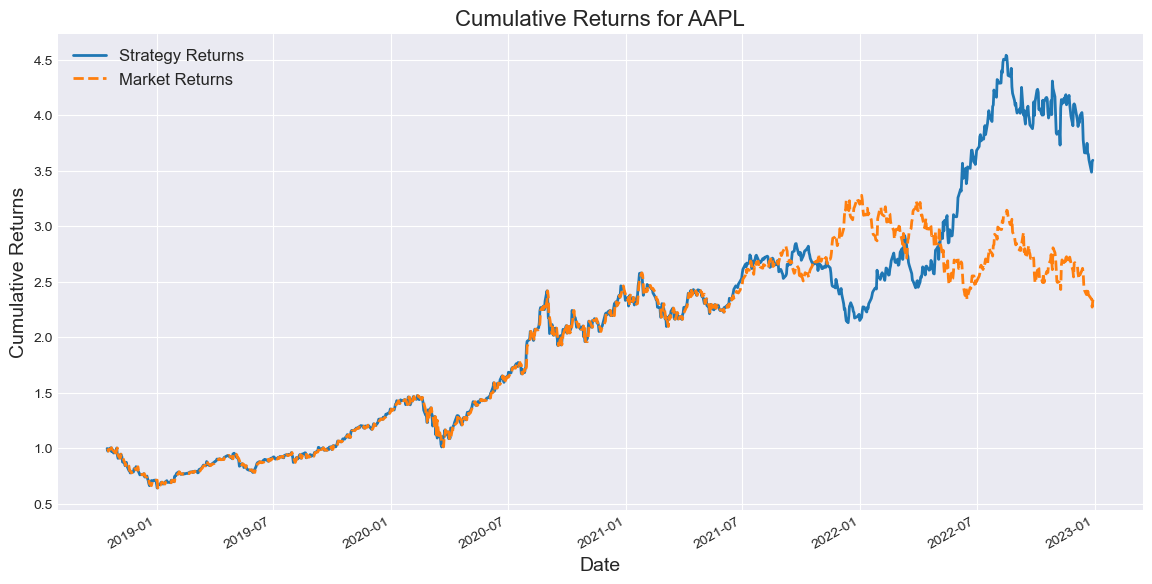

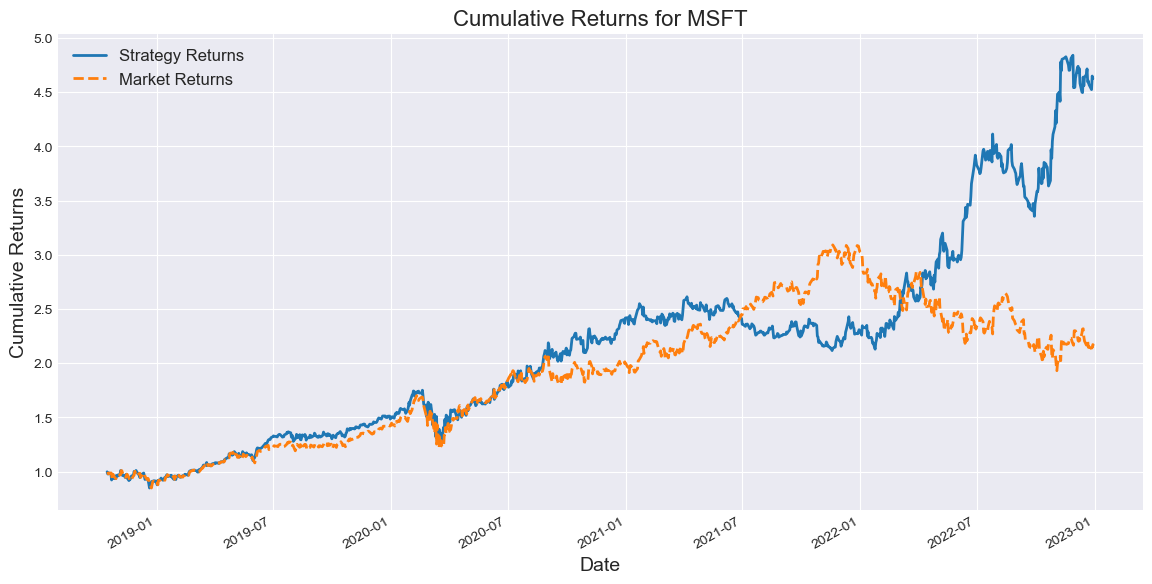

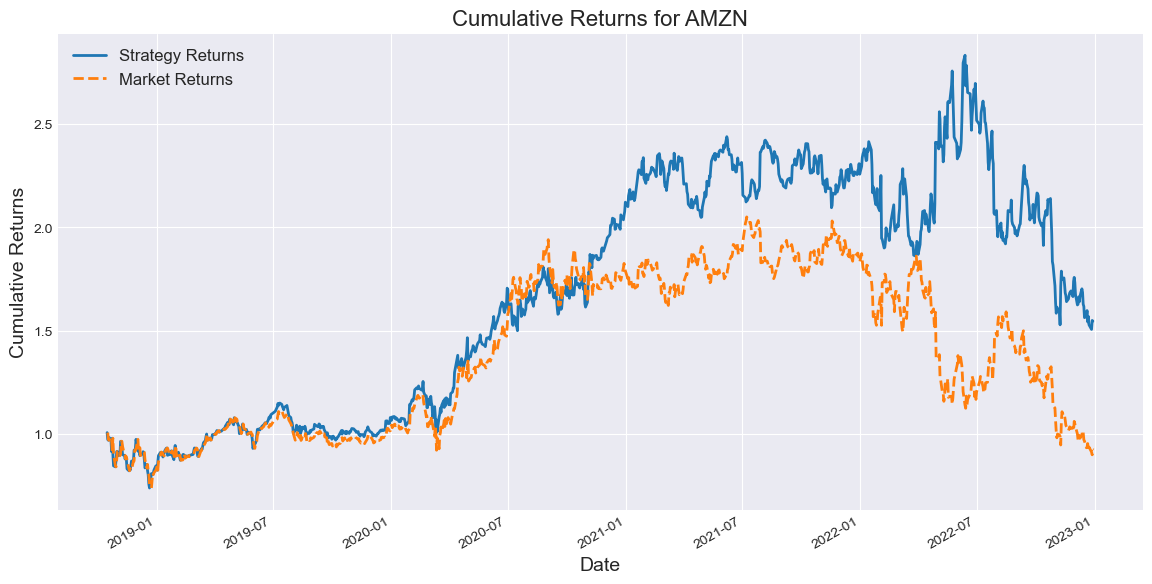

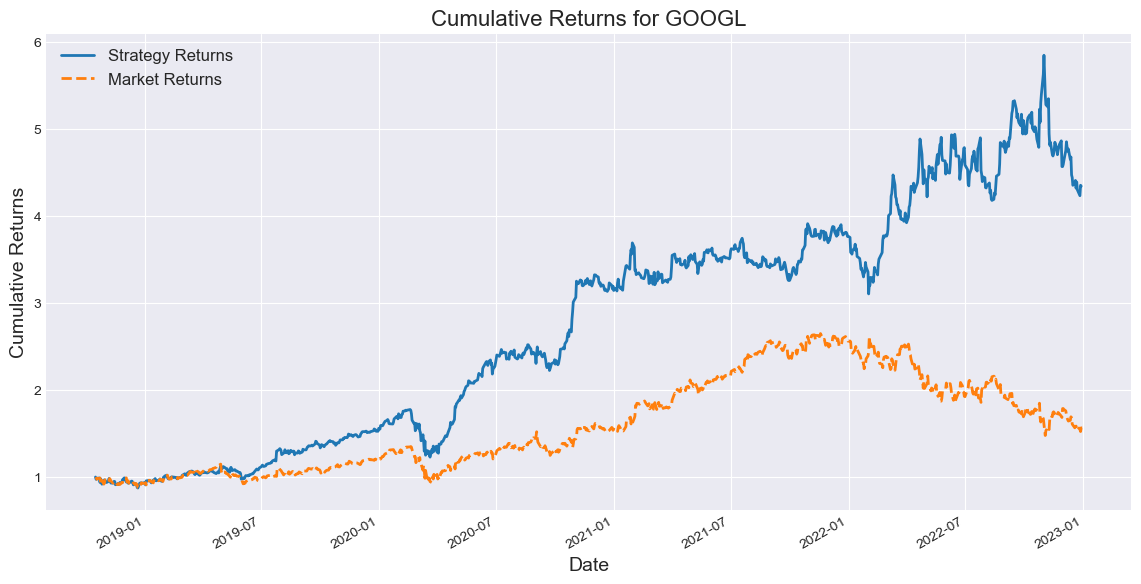

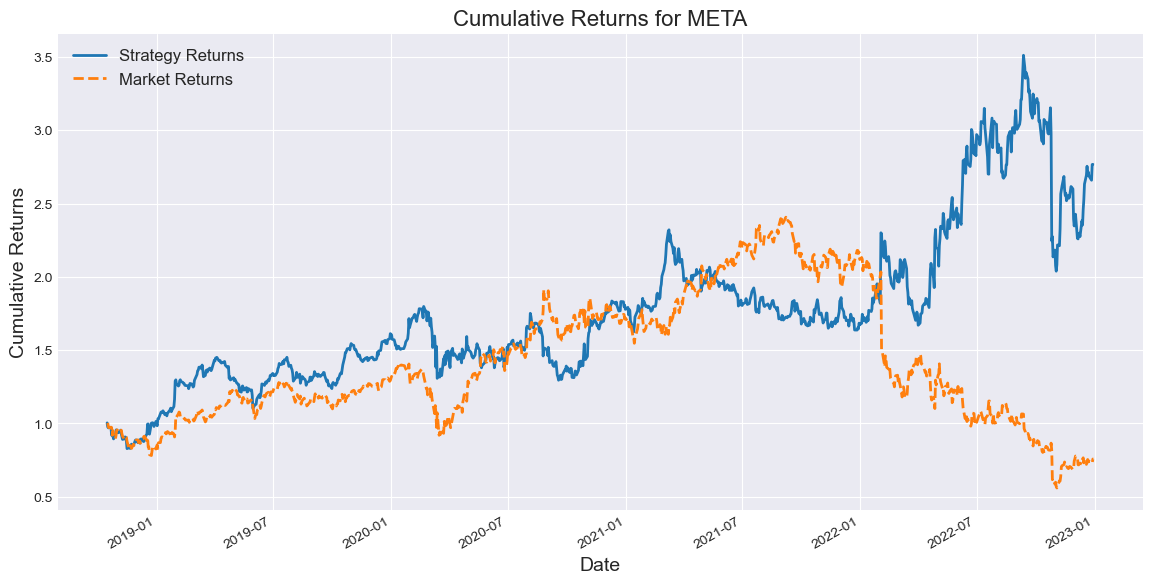

In [17]:
def backtest_strategy(df, model):
    # Drop NaN values
    df = df.dropna()
    
    # Predict next day's return
    features = df[['MA_50', 'MA_200', 'Upper_Band', 'Lower_Band', 'RSI']]
    df['Predicted_Next_Return'] = model.predict(features)
    
    # Define trading strategy
    df['Strategy_Return'] = df['Close'].pct_change().shift(-1) * df['Predicted_Next_Return'].apply(lambda x: 1 if x > 0 else -1)
    
    # Calculate cumulative returns
    df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Return']).cumprod()
    df['Cumulative_Market_Returns'] = (1 + df['Close'].pct_change()).cumprod()
    
    return df

# Backtest the strategy for each stock
backtest_results = {}
for ticker, model in models.items():
    backtest_results[ticker] = backtest_strategy(stock_data[ticker], model)

plt.style.use('seaborn-darkgrid')

for ticker, result in backtest_results.items():
    plt.figure(figsize=(14,7))
    
    # Plotting the cumulative returns
    result['Cumulative_Strategy_Returns'].plot(label='Strategy Returns', linewidth=2)
    result['Cumulative_Market_Returns'].plot(label='Market Returns', linewidth=2, linestyle='--')
    
    # Adding title and labels
    plt.title(f"Cumulative Returns for {ticker}", fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Cumulative Returns', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    
    # Display the plot
    plt.show()


In [25]:
def compute_metrics(df):
    # Drop rows with missing values in Strategy_Return column
    df = df.dropna(subset=['Strategy_Return'])
    
    # Annualized Returns
    total_days = len(df)
    total_return = df['Cumulative_Strategy_Returns'].iloc[-1] - 1
    annualized_return = ((1 + total_return)**(252/total_days)) - 1
    
    # Annualized Volatility
    annualized_vol = df['Strategy_Return'].std() * np.sqrt(252)
    
    # Sharpe Ratio (assuming a risk-free rate of 2%)
    sharpe_ratio = (annualized_return - 0.02) / annualized_vol
    
    # Maximum Drawdown
    df['Cumulative_Rolling_Max'] = df['Cumulative_Strategy_Returns'].cummax()
    df['Drawdown'] = df['Cumulative_Strategy_Returns'] / df['Cumulative_Rolling_Max'] - 1
    max_drawdown = df['Drawdown'].min()
    
    return annualized_return, annualized_vol, sharpe_ratio, max_drawdown

# Recompute the metrics using the revised function
metrics = {}
for ticker, result in backtest_results.items():
    metrics[ticker] = compute_metrics(result)

# Display the metrics
for ticker, values in metrics.items():
    print(f"Metrics for {ticker}:")
    print(f"Annualized Return: {values[0]:.2%}")
    print(f"Annualized Volatility: {values[1]:.2%}")
    print(f"Sharpe Ratio: {values[2]:.2f}")
    print(f"Maximum Drawdown: {values[3]:.2%}")
    print("-" * 50)

Metrics for AAPL:
Annualized Return: 35.57%
Annualized Volatility: 34.97%
Sharpe Ratio: 0.96
Maximum Drawdown: -36.16%
--------------------------------------------------
Metrics for MSFT:
Annualized Return: 43.98%
Annualized Volatility: 32.04%
Sharpe Ratio: 1.31
Maximum Drawdown: -26.57%
--------------------------------------------------
Metrics for AMZN:
Annualized Return: 10.93%
Annualized Volatility: 37.14%
Sharpe Ratio: 0.24
Maximum Drawdown: -46.84%
--------------------------------------------------
Metrics for GOOGL:
Annualized Return: 41.80%
Annualized Volatility: 32.30%
Sharpe Ratio: 1.23
Maximum Drawdown: -30.87%
--------------------------------------------------
Metrics for META:
Annualized Return: 27.41%
Annualized Volatility: 44.34%
Sharpe Ratio: 0.57
Maximum Drawdown: -41.94%
--------------------------------------------------


In [32]:
import pandas as pd
import numpy as np

def add_macd(df):
    # Calculate the Short Term Exponential Moving Average
    ShortEMA = df.Close.ewm(span=12, adjust=False).mean() 

    # Calculate the Long Term Exponential Moving Average
    LongEMA = df.Close.ewm(span=26, adjust=False).mean() 

    # Calculate the Moving Average Convergence/Divergence (MACD)
    df['MACD'] = ShortEMA - LongEMA

    # Calculate the signal line
    df['Signal_Line'] = df.MACD.ewm(span=9, adjust=False).mean()

    # MACD Signal
    df['MACD_Signal'] = df['MACD'] - df['Signal_Line']

    return df

def refined_strategy(df, model, threshold=0.005):  # 0.5% threshold
    # Add MACD to the dataframe
    df = add_macd(df)
    
    # Drop rows with NaN values
    df = df.dropna()

    # Predict next day's return using the original features
    features = df[['MA_50', 'MA_200', 'Upper_Band', 'Lower_Band', 'RSI']]
    df['Predicted_Next_Return'] = model.predict(features)
    
    # Define trading strategy with threshold
    df['Strategy_Return'] = np.where(df['Predicted_Next_Return'] > threshold, df['Close'].pct_change().shift(-1), 0)
    df['Strategy_Return'] = np.where(df['Predicted_Next_Return'] < -threshold, -df['Close'].pct_change().shift(-1), df['Strategy_Return'])
    
    # Calculate cumulative returns
    df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Return']).cumprod()
    
    return df

# Apply the refined strategy
refined_results = {}
for ticker, model in models.items():
    refined_results[ticker] = refined_strategy(stock_data[ticker], model)


In [33]:
def compute_metrics(df):
    # Drop rows with missing values in Strategy_Return column
    df = df.dropna(subset=['Strategy_Return'])
    
    # Annualized Returns
    total_days = len(df)
    total_return = df['Cumulative_Strategy_Returns'].iloc[-1] - 1
    annualized_return = ((1 + total_return)**(252/total_days)) - 1
    
    # Annualized Volatility
    annualized_vol = df['Strategy_Return'].std() * np.sqrt(252)
    
    # Sharpe Ratio (assuming a risk-free rate of 2%)
    sharpe_ratio = (annualized_return - 0.02) / annualized_vol
    
    # Maximum Drawdown
    df['Cumulative_Rolling_Max'] = df['Cumulative_Strategy_Returns'].cummax()
    df['Drawdown'] = df['Cumulative_Strategy_Returns'] / df['Cumulative_Rolling_Max'] - 1
    max_drawdown = df['Drawdown'].min()
    
    return annualized_return, annualized_vol, sharpe_ratio, max_drawdown

# Compute the metrics for the refined strategy
refined_metrics = {}
for ticker, result in refined_results.items():
    refined_metrics[ticker] = compute_metrics(result)

# Display the metrics
for ticker, values in refined_metrics.items():
    print(f"Metrics for {ticker}:")
    print(f"Annualized Return: {values[0]:.2%}")
    print(f"Annualized Volatility: {values[1]:.2%}")
    print(f"Sharpe Ratio: {values[2]:.2f}")
    print(f"Maximum Drawdown: {values[3]:.2%}")
    print("-" * 50)

Metrics for AAPL:
Annualized Return: 0.00%
Annualized Volatility: 0.00%
Sharpe Ratio: -inf
Maximum Drawdown: 0.00%
--------------------------------------------------
Metrics for MSFT:
Annualized Return: 0.56%
Annualized Volatility: 3.90%
Sharpe Ratio: -0.37
Maximum Drawdown: -4.17%
--------------------------------------------------
Metrics for AMZN:
Annualized Return: 0.00%
Annualized Volatility: 0.00%
Sharpe Ratio: -inf
Maximum Drawdown: 0.00%
--------------------------------------------------
Metrics for GOOGL:
Annualized Return: 5.36%
Annualized Volatility: 4.55%
Sharpe Ratio: 0.74
Maximum Drawdown: -2.01%
--------------------------------------------------
Metrics for META:
Annualized Return: 3.89%
Annualized Volatility: 14.96%
Sharpe Ratio: 0.13
Maximum Drawdown: -19.37%
--------------------------------------------------


In [34]:
def add_additional_indicators(df):
    # Bollinger Bandwidth
    df['BB_Width'] = (df['Upper_Band'] - df['Lower_Band']) / df['MA_50']

    # Momentum (Rate of Change)
    df['Momentum'] = df['Close'].diff(4)  # 4-day momentum

    return df

# Add the new indicators to the stock data
for ticker in stock_data.keys():
    stock_data[ticker] = add_additional_indicators(stock_data[ticker])

In [35]:
def updated_refined_strategy(df, model, threshold=0.003):  # Adjusted threshold to 0.3%
    # Drop rows with NaN values
    df = df.dropna()

    # Predict next day's return using the updated features
    features = df[['MA_50', 'MA_200', 'Upper_Band', 'Lower_Band', 'RSI', 'MACD_Signal', 'BB_Width', 'Momentum']]
    df['Predicted_Next_Return'] = model.predict(features)
    
    # Define trading strategy with adjusted threshold
    df['Strategy_Return'] = np.where(df['Predicted_Next_Return'] > threshold, df['Close'].pct_change().shift(-1), 0)
    df['Strategy_Return'] = np.where(df['Predicted_Next_Return'] < -threshold, -df['Close'].pct_change().shift(-1), df['Strategy_Return'])
    
    # Calculate cumulative returns
    df['Cumulative_Strategy_Returns'] = (1 + df['Strategy_Return']).cumprod()
    
    return df

In [36]:
def apply_stop_loss_take_profit(df, stop_loss=-0.02, take_profit=0.05):
    """
    Apply stop-loss and take-profit rules to the strategy returns.
    """
    # Create a new column for adjusted strategy returns
    df['Adjusted_Strategy_Return'] = df['Strategy_Return']

    # Loop through the DataFrame and adjust returns based on stop-loss/take-profit
    in_trade = False
    for i in range(1, len(df)):
        if df['Strategy_Return'].iloc[i] != 0 and not in_trade:
            # Start of a new trade
            in_trade = True
            entry_price = df['Close'].iloc[i]
        
        elif in_trade:
            # Check if stop-loss or take-profit is hit
            current_return = (df['Close'].iloc[i] - entry_price) / entry_price
            if current_return <= stop_loss:
                df['Adjusted_Strategy_Return'].iloc[i] = (1 + df['Strategy_Return'].iloc[i]) * (1 + stop_loss) - 1
                in_trade = False
            elif current_return >= take_profit:
                df['Adjusted_Strategy_Return'].iloc[i] = (1 + df['Strategy_Return'].iloc[i]) * (1 + take_profit) - 1
                in_trade = False

    # Calculate cumulative returns using the adjusted strategy returns
    df['Cumulative_Adjusted_Strategy_Returns'] = (1 + df['Adjusted_Strategy_Return']).cumprod()

    return df

# Apply stop-loss and take-profit to the refined strategy results
for ticker, result in refined_results.items():
    refined_results[ticker] = apply_stop_loss_take_profit(result)

In [37]:
def dynamic_position_sizing(df):
    """
    Adjust strategy returns based on the magnitude of the predicted return.
    """
    # Define a base position size
    base_position = 1.0

    # Adjust the position size based on the predicted return
    df['Adjusted_Position'] = base_position + (df['Predicted_Next_Return'] * base_position)
    
    # Adjust the strategy return based on the adjusted position size
    df['Dynamic_Strategy_Return'] = df['Strategy_Return'] * df['Adjusted_Position']

    return df

# Apply dynamic position sizing to the refined strategy results
for ticker, result in refined_results.items():
    refined_results[ticker] = dynamic_position_sizing(result)
